# Basic Version w/ Transfer Learning & Fine-tuning
For this approach, it will be used a pretrained DenseNet201, to which we will apply transfer learning and fine-tuning for our task.

In [2]:
import os

DATA_DIR = "../data/"
IMG_DIR = DATA_DIR + "/images/"
ANNOTATION_DIR = DATA_DIR + "/annotations/"
SPLITS_DIR = DATA_DIR + "/dl-split/"
OUT_DIR = "./out/basic_fine_tuned/"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Utility Function

In [33]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

## Load Dataset

In [3]:
# Fetching pre-defined splits
train_split = []
test_split = []

with open(SPLITS_DIR + "/train.txt") as train_split_f:
    train_split = [line.strip("\n") for line in train_split_f.readlines()]

with open(SPLITS_DIR + "/test.txt") as test_split_f:
    test_split = [line.strip("\n") for line in test_split_f.readlines()]

In [4]:
# Label mapping
label_encode_map = {
    "background": -100,
    "trafficlight": 0,
    "speedlimit": 1,
    "crosswalk": 2,
    "stop": 3,
}

label_decode_map = {
    -100: "background",
    0: "trafficlight",
    1: "speedlimit",
    2: "crosswalk",
    3: "stop",
}

In [5]:
from datasets.road_sign_dataset import RoadSignDataset

# Training dataset
training_data = RoadSignDataset(
    img_names=train_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False
)

# Test dataset
testing_data = RoadSignDataset(
    img_names=test_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=False,
    multilabel=False
)

# Split training dataset into train and validation splits

In [6]:
import numpy as np
from torch.utils.data import SubsetRandomSampler

np.random.seed(SEED)

train_indices = list(range(len(training_data)))
np.random.shuffle(train_indices)
train_val_split = int(np.floor(0.2 * len(train_indices)))

train_idx, val_idx = train_indices[train_val_split:], train_indices[:train_val_split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create Dataloaders

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 # Tested on 1050TI with 4GB (can load at least 64 as well, but doesn't make sense to use 64 with low amount of data)
NUM_WORKERS = 4

train_dataloader = DataLoader(
    dataset=training_data,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=training_data,
    sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

test_dataloader = DataLoader(
    dataset=testing_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=False,
    collate_fn=testing_data.collate_fn
)

# Model Definition

In [8]:
from torchvision import models
from torch import nn
from torchinfo import summary

MODEL_NAME = "BASIC_FINE_TUNED"
N_CLASSES = 4

def get_model(n_classes):
    model = models.densenet201(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(
        in_features=in_features,
        out_features=n_classes,
        bias=True
    )

    return model

model = get_model(n_classes=N_CLASSES)

summary(model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

# Define Optimizer, LR Scheduler, Loss function and Metric Scorer

In [9]:
from torch import optim
import torchmetrics

optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.9
)

loss_fn = nn.CrossEntropyLoss(ignore_index=label_encode_map["background"])

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
)

# Define Epoch Iteration

In [42]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def epoch_iter(dataloader, model, loss_fn, device, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    probs = []
    preds = []
    expected_labels = []
    imageIds = []

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            labels = y["labels"]
            ids = y["imageIds"]

            X, y = X.to(device), labels.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()

            prob = F.softmax(pred, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(y.detach().cpu().numpy())
            imageIds.extend([f"road{imageId}" for imageId in ids.detach().cpu().numpy()])

        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
    

    return (expected_labels, preds, probs, imageIds), total_loss / num_batches

# Train Model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [11]:
NUM_EPOCHS = 30

model.to(device)
model.features.requires_grad_(False) # Freeze feature layer

train_history = {
    "loss": [],
    "accuracy": [],
}

val_history = {
    "loss": [],
    "accuracy": [],
}

best_val_loss = np.inf
best_val_accuracy = 0
best_epoch = -1

print(f"Starting {MODEL_NAME} training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_latest_model.pth")

    # Save loss and accuracy in history
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_val_loss}\t Accuracy on best epoch: {best_val_accuracy}"
)

Starting BASIC_FINE_TUNED training...
Epoch[0/30]


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training loss: 0.998	 Training micro accuracy: 0.682


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Validation loss: 0.799	 Validation micro accuracy: 0.747
----------------------------------------------------------------
Epoch[1/30]


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Training loss: 0.792	 Training micro accuracy: 0.753


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Validation loss: 0.608	 Validation micro accuracy: 0.769
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training loss: 0.659	 Training micro accuracy: 0.771


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Validation loss: 0.553	 Validation micro accuracy: 0.828
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


Training loss: 0.581	 Training micro accuracy: 0.785


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Validation loss: 0.564	 Validation micro accuracy: 0.796
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training loss: 0.522	 Training micro accuracy: 0.808


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation loss: 0.489	 Validation micro accuracy: 0.822
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Training loss: 0.463	 Training micro accuracy: 0.825


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Validation loss: 0.480	 Validation micro accuracy: 0.815
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Training loss: 0.442	 Training micro accuracy: 0.855


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Validation loss: 0.446	 Validation micro accuracy: 0.859
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Training loss: 0.418	 Training micro accuracy: 0.852


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Validation loss: 0.441	 Validation micro accuracy: 0.854
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training loss: 0.388	 Training micro accuracy: 0.865


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Validation loss: 0.424	 Validation micro accuracy: 0.872
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Training loss: 0.431	 Training micro accuracy: 0.849


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Validation loss: 0.418	 Validation micro accuracy: 0.867
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Training loss: 0.383	 Training micro accuracy: 0.860


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Validation loss: 0.408	 Validation micro accuracy: 0.864
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training loss: 0.383	 Training micro accuracy: 0.857


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Validation loss: 0.349	 Validation micro accuracy: 0.912
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training loss: 0.371	 Training micro accuracy: 0.878


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Validation loss: 0.365	 Validation micro accuracy: 0.890
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training loss: 0.350	 Training micro accuracy: 0.895


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Validation loss: 0.352	 Validation micro accuracy: 0.859
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Training loss: 0.336	 Training micro accuracy: 0.902


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Validation loss: 0.332	 Validation micro accuracy: 0.897
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Training loss: 0.334	 Training micro accuracy: 0.905


100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


Validation loss: 0.359	 Validation micro accuracy: 0.890
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Training loss: 0.325	 Training micro accuracy: 0.884


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Validation loss: 0.356	 Validation micro accuracy: 0.888
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training loss: 0.345	 Training micro accuracy: 0.897


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Validation loss: 0.284	 Validation micro accuracy: 0.911
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training loss: 0.338	 Training micro accuracy: 0.915


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Validation loss: 0.267	 Validation micro accuracy: 0.930
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training loss: 0.348	 Training micro accuracy: 0.873


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Validation loss: 0.357	 Validation micro accuracy: 0.899
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Training loss: 0.304	 Training micro accuracy: 0.923


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


Validation loss: 0.341	 Validation micro accuracy: 0.898
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training loss: 0.316	 Training micro accuracy: 0.890


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Validation loss: 0.298	 Validation micro accuracy: 0.911
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Training loss: 0.344	 Training micro accuracy: 0.902


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


Validation loss: 0.388	 Validation micro accuracy: 0.865
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training loss: 0.314	 Training micro accuracy: 0.894


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Validation loss: 0.320	 Validation micro accuracy: 0.888
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training loss: 0.333	 Training micro accuracy: 0.895


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Validation loss: 0.265	 Validation micro accuracy: 0.922
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Training loss: 0.303	 Training micro accuracy: 0.906


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Validation loss: 0.381	 Validation micro accuracy: 0.889
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training loss: 0.317	 Training micro accuracy: 0.913


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation loss: 0.368	 Validation micro accuracy: 0.885
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training loss: 0.307	 Training micro accuracy: 0.891


100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation loss: 0.336	 Validation micro accuracy: 0.879
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Training loss: 0.338	 Training micro accuracy: 0.889


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Validation loss: 0.333	 Validation micro accuracy: 0.900
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Training loss: 0.301	 Training micro accuracy: 0.917


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Validation loss: 0.342	 Validation micro accuracy: 0.913
----------------------------------------------------------------

Finished training...
Best epoch: 24	 Validation loss on best epoch: 0.26516737540562946	 Accuracy on best epoch: 0.9222221970558167


In [ ]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name=MODEL_NAME, phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [12]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(3543112091, 4294836224)

In [13]:
!nvidia-smi

Fri Jun  3 09:46:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0    N/A /  N/A |     39MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-tune the model

Load best model from first training session

In [14]:
BATCH_SIZE = 8 # Have to reduce batch size otherwise GPU memory dies (tested on 1050TI with 4GB)

train_dataloader = DataLoader(
    dataset=training_data,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=training_data,
    sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

In [15]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best model...")

Loaded best model...


In [16]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9
)

In [17]:
FT_NUM_EPOCHS = 15
model.features.requires_grad_(True) # Unfreeze feature layer for fine-tuning

ft_train_history = {
    "loss": [],
    "accuracy": [],
}

ft_val_history = {
    "loss": [],
    "accuracy": [],
}

ft_best_val_loss = 0.26516737540562946 # best_val_loss
ft_best_val_accuracy = 0.9222221970558167 # best_val_accuracy
ft_best_epoch = -1

print(f"Starting {MODEL_NAME} fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < ft_best_val_loss:
        ft_best_val_loss = val_loss
        ft_best_val_accuracy = val_accuracy
        ft_best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_latest_model.pth")

    # Save loss and accuracy in history
    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_val_loss}\t Accuracy on best epoch: {ft_best_val_accuracy}"
)

Starting BASIC_FINE_TUNED fine-tuning...
Epoch[0/15]


100%|██████████| 61/61 [00:30<00:00,  2.00it/s]


Training loss: 0.360	 Training micro accuracy: 0.867


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Validation loss: 0.328	 Validation micro accuracy: 0.922
----------------------------------------------------------------
Epoch[1/15]


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


Training loss: 0.305	 Training micro accuracy: 0.916


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Validation loss: 0.260	 Validation micro accuracy: 0.930
----------------------------------------------------------------
Epoch[2/15]


100%|██████████| 61/61 [00:29<00:00,  2.07it/s]


Training loss: 0.248	 Training micro accuracy: 0.953


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Validation loss: 0.198	 Validation micro accuracy: 0.973
----------------------------------------------------------------
Epoch[3/15]


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


Training loss: 0.244	 Training micro accuracy: 0.938


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Validation loss: 0.233	 Validation micro accuracy: 0.931
----------------------------------------------------------------
Epoch[4/15]


100%|██████████| 61/61 [00:29<00:00,  2.09it/s]


Training loss: 0.210	 Training micro accuracy: 0.950


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Validation loss: 0.217	 Validation micro accuracy: 0.964
----------------------------------------------------------------
Epoch[5/15]


100%|██████████| 61/61 [00:29<00:00,  2.07it/s]


Training loss: 0.238	 Training micro accuracy: 0.932


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Validation loss: 0.145	 Validation micro accuracy: 0.973
----------------------------------------------------------------
Epoch[6/15]


100%|██████████| 61/61 [00:29<00:00,  2.08it/s]


Training loss: 0.199	 Training micro accuracy: 0.948


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Validation loss: 0.172	 Validation micro accuracy: 0.964
----------------------------------------------------------------
Epoch[7/15]


100%|██████████| 61/61 [00:30<00:00,  2.01it/s]


Training loss: 0.231	 Training micro accuracy: 0.930


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Validation loss: 0.165	 Validation micro accuracy: 0.964
----------------------------------------------------------------
Epoch[8/15]


100%|██████████| 61/61 [00:30<00:00,  2.02it/s]


Training loss: 0.169	 Training micro accuracy: 0.957


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Validation loss: 0.127	 Validation micro accuracy: 0.965
----------------------------------------------------------------
Epoch[9/15]


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


Training loss: 0.199	 Training micro accuracy: 0.952


100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


Validation loss: 0.152	 Validation micro accuracy: 0.982
----------------------------------------------------------------
Epoch[10/15]


100%|██████████| 61/61 [00:29<00:00,  2.07it/s]


Training loss: 0.155	 Training micro accuracy: 0.968


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Validation loss: 0.149	 Validation micro accuracy: 0.946
----------------------------------------------------------------
Epoch[11/15]


100%|██████████| 61/61 [00:29<00:00,  2.08it/s]


Training loss: 0.195	 Training micro accuracy: 0.951


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Validation loss: 0.171	 Validation micro accuracy: 0.973
----------------------------------------------------------------
Epoch[12/15]


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]


Training loss: 0.186	 Training micro accuracy: 0.957


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Validation loss: 0.138	 Validation micro accuracy: 0.965
----------------------------------------------------------------
Epoch[13/15]


100%|██████████| 61/61 [00:30<00:00,  1.97it/s]


Training loss: 0.133	 Training micro accuracy: 0.970


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Validation loss: 0.253	 Validation micro accuracy: 0.945
----------------------------------------------------------------
Epoch[14/15]


100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


Training loss: 0.181	 Training micro accuracy: 0.954


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Validation loss: 0.125	 Validation micro accuracy: 0.973
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 14	 Validation loss on best epoch: 0.12450087492664655	 Accuracy on best epoch: 0.9734513163566589


C:\Users\telmo\AppData\Local\Temp/ipykernel_20336/1559553078.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


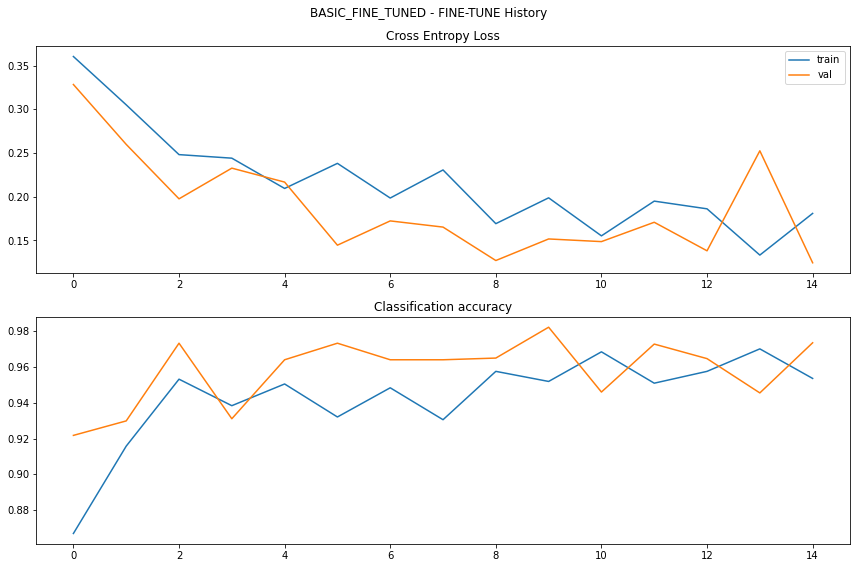

In [34]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name=MODEL_NAME, phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

Clean GPU memory again

In [40]:
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2537724315, 4294836224)

# Test the model

In [41]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best fine-tuned model...")

Loaded best fine-tuned model...


In [43]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    loss_fn=loss_fn,
    device=device,
    is_train=False,
)

100%|██████████| 264/264 [00:17<00:00, 15.26it/s]


In [53]:
np.unique(test_preds)

array([0, 1, 2, 3], dtype=int64)

In [62]:
test_metrics = torchmetrics.MetricCollection(
    metrics={
        "micro_accuracy": metric_scorer,
        "macro_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        ),
        "micro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="micro",
        ),
        "macro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        )
    }
)

test_probs_tensor = torch.tensor(np.array(test_probs))
test_target_tensor = torch.tensor(np.array(test_target))

test_metrics_scores = test_metrics(test_probs_tensor, test_target_tensor)

print(test_metrics_scores)

{'macro_accuracy': tensor(0.8557), 'macro_f1_score': tensor(0.8847), 'micro_accuracy': tensor(0.9432), 'micro_f1_score': tensor(0.9432), 'weighted_accuracy': tensor(0.9432), 'weighted_f1_score': tensor(0.9394)}


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=list(label_encode_map.keys())[1:]))

              precision    recall  f1-score   support

trafficlight       0.92      0.96      0.94        24
  speedlimit       0.95      0.99      0.97       192
   crosswalk       0.83      0.60      0.70        25
        stop       1.00      0.87      0.93        23

    accuracy                           0.94       264
   macro avg       0.93      0.86      0.88       264
weighted avg       0.94      0.94      0.94       264

